# Importing libraries

In [1]:
import csv
import datetime
import re
from itertools import product
from math import ceil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import ticker
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics import pairwise_distances
import squarify
import category_encoders as ce

In [2]:
subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 10
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 10
heatmaps_text_fontSize = 8

plots_Title_fontSize = 14
plots_Title_textColour = 'black'

plots_Legend_fontSize = 12
plots_Legend_textColour = 'black'

# Data cleaning of sheet reviews

In [3]:
reviews = pd.read_excel('EuropeTop100Attractions_ENG_20190101_20210821.xlsx', sheet_name='Reviews', decimal=",")
reviews.describe(include='all', datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
localID,92120,100,MAG001,8309,NaN,NaN,NaN,NaN,NaN,NaN,NaN
extractionDate,92120,NaN,NaN,NaN,2021-08-20 22:09:20.598932992,2021-08-20 08:24:40.077000,2021-08-20 12:08:10.831000064,2021-08-20 15:46:58.171000064,2021-08-21 12:35:39.817250048,2021-08-21 16:27:17.026000,NaN
globalRating,92120.0,NaN,NaN,NaN,4.485166,4.0,4.5,4.5,4.5,5.0,0.178085
positionOnRanking,92120.0,NaN,NaN,NaN,3.91459,1.0,1.0,2.0,6.0,55.0,4.843013
sitesOnRanking,92120.0,NaN,NaN,NaN,748.263537,5.0,154.0,484.0,1186.0,3837.0,802.742304
totalReviews,92120.0,NaN,NaN,NaN,40556.601813,5179.0,14152.0,24454.0,51324.0,163828.0,42914.381014
userName,92100,65785,Malgorzata@Margo7850p,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userLocation,78652,12613,"London, UK",3710,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userContributions,92120.0,NaN,NaN,NaN,477.52056,0.0,20.0,66.0,215.0,607732.0,7270.518677
tripType,63052,5,Couples,31702,NaN,NaN,NaN,NaN,NaN,NaN,NaN


we can see from here that the extraction date takes two days, which later turn out to be a usefull information

In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92120 entries, 0 to 92119
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   localID            92120 non-null  object        
 1   extractionDate     92120 non-null  datetime64[ns]
 2   globalRating       92120 non-null  float64       
 3   positionOnRanking  92120 non-null  int64         
 4   sitesOnRanking     92120 non-null  int64         
 5   totalReviews       92120 non-null  int64         
 6   userName           92100 non-null  object        
 7   userLocation       78652 non-null  object        
 8   userContributions  92120 non-null  int64         
 9   tripType           63052 non-null  object        
 10  reviewWritten      92120 non-null  datetime64[ns]
 11  reviewVisited      91410 non-null  datetime64[ns]
 12  reviewRating       92120 non-null  int64         
 13  reviewLanguage     92120 non-null  object        
 14  review

In [5]:
# drop the columns extractionDate, reviewLanguage, positionOnRanking, sitesOnRanking from dataset named reviews
reviews.drop(['extractionDate','reviewLanguage','positionOnRanking','sitesOnRanking'], axis=1, inplace=True)

Changing some names of location that we found that are wrong.

Here we perform a regex in order to see if some attraction have ID that are not matching the schema.

In [6]:
reviews[False == reviews['localID'].apply(lambda x: bool(re.match(r'^MAG\d{3}$', x)))].drop_duplicates(subset=['localID']).head()
 

,localID,globalRating,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewFullText
18500,genis,4.5,55541,Adrian's_Quests@Adrians_Quests,"Weiden, Germany",371,NaN,2021-08-18,2021-08-01,5,"A very clean, well kept city center, a conglom..."
19000,u,4.5,51324,Chris C@chriscX807MN,NaN,7,Family,2021-08-19,2021-08-01,4,Interesting visit. Lots to see. Staff very hel...


Here we change the name of the wrong IDs.

In [7]:
reviews['localID'] = np.where(reviews['localID']=='genis','MAG005',reviews['localID'])
reviews['localID'] = np.where(reviews['localID']=='u','MAG006',reviews['localID'])

We drop duplicates, and see how this effect the number of non-null observations for each feature.

In [8]:
reviews.drop_duplicates(inplace=True) 
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85108 entries, 0 to 92119
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   localID            85108 non-null  object        
 1   globalRating       85108 non-null  float64       
 2   totalReviews       85108 non-null  int64         
 3   userName           85088 non-null  object        
 4   userLocation       72670 non-null  object        
 5   userContributions  85108 non-null  int64         
 6   tripType           58189 non-null  object        
 7   reviewWritten      85108 non-null  datetime64[ns]
 8   reviewVisited      84450 non-null  datetime64[ns]
 9   reviewRating       85108 non-null  int64         
 10  reviewFullText     85108 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(5)
memory usage: 7.8+ MB


In [9]:
reviews[reviews.duplicated(subset=["reviewFullText"], keep = False)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 1061 to 83246
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   localID            38 non-null     object        
 1   globalRating       38 non-null     float64       
 2   totalReviews       38 non-null     int64         
 3   userName           38 non-null     object        
 4   userLocation       30 non-null     object        
 5   userContributions  38 non-null     int64         
 6   tripType           22 non-null     object        
 7   reviewWritten      38 non-null     datetime64[ns]
 8   reviewVisited      37 non-null     datetime64[ns]
 9   reviewRating       38 non-null     int64         
 10  reviewFullText     38 non-null     object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(5)
memory usage: 3.6+ KB


Here you can see why we have duplicated reviews, is because there is an issue on how the data were extracted so we have some reviews that have the same text but actually are different reviews.

In [10]:
reviews[reviews.duplicated(subset=["reviewFullText"], keep = False)].head(30) # with keep false we can see all the duplicates

,localID,globalRating,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewFullText
1061,MAG001,4.5,163828,olimpya@olimpya79,"Barcelona, Spain",13,NaN,2019-12-18,2019-11-01,5,"spectacular monument, well organized with the ..."
2721,MAG001,4.5,163828,Blue Eagletje@Blue_Eagletje,NaN,4,NaN,2019-09-26,2019-09-01,1,We had to be there on Sunday 22-09-2019 at 1.1...
2729,MAG001,4.5,163828,Blue Eagletje@Blue_Eagletje,NaN,4,NaN,2019-09-25,2019-09-01,1,We had to be there on Sunday 22-09-2019 at 1.1...
7574,MAG001,4.5,163828,mrbmclean@mrbmclean,"Barcelona, Spain",102,Couples,2019-02-19,2019-02-01,5,We had an absolutely wonderful time and it is ...
9905,MAG002,4.0,75909,Bluebonet@Bluebonet,"Houston, TX",176,Couples,2019-06-23,2019-05-01,5,Amazing Architecture that is best described as...
10887,MAG002,4.0,75909,mrbmclean@mrbmclean,"Barcelona, Spain",102,NaN,2019-02-19,2019-02-01,5,We had an absolutely wonderful time and it is ...
16796,MAG004,4.5,57180,Sam@Tourist36708628704,NaN,12,Couples,2020-02-24,2020-02-01,4,Is a nice place to visit when you visit Barcel...
17267,MAG004,4.5,57180,David F@426DavidF426,"Campinas, SP",65,Couples,2019-10-09,2019-10-01,5,Great attraction must item in you schedule.we ...
17821,MAG004,4.5,57180,Bluebonet@Bluebonet,"Houston, TX",176,Couples,2019-06-23,2019-05-01,5,Amazing Architecture that is best described as...
18419,MAG004,4.5,57180,c0achdena@c0achdena,"Media, PA",21,Couples,2019-01-17,2019-01-01,5,We visited several Gaudi houses in Barcelona a...


We keep the last one and not the first one because seems like that these are reviews that are been modified, so the last occurence is the right one

In [11]:
# drop the duplicated rows from column reviewFullText in the dataset named reviews
reviews.drop_duplicates(subset=['reviewFullText'], inplace=True, keep='last')

droping rows with empty userName

In [12]:
reviews.dropna(subset=['userName'], inplace=True)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85068 entries, 0 to 92119
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   localID            85068 non-null  object        
 1   globalRating       85068 non-null  float64       
 2   totalReviews       85068 non-null  int64         
 3   userName           85068 non-null  object        
 4   userLocation       72654 non-null  object        
 5   userContributions  85068 non-null  int64         
 6   tripType           58179 non-null  object        
 7   reviewWritten      85068 non-null  datetime64[ns]
 8   reviewVisited      84431 non-null  datetime64[ns]
 9   reviewRating       85068 non-null  int64         
 10  reviewFullText     85068 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(5)
memory usage: 7.8+ MB


In [13]:
def is_number(x):
    return bool(re.match(r'^\d+$', str(x)))
    
reviews['userLocation'] = np.where(reviews['userLocation'].apply(is_number), np.nan, reviews['userLocation'])

Just take a look on how many nan values we have now after the cleaning that we performed

In [14]:
reviews.isna().sum()

localID                  0
globalRating             0
totalReviews             0
userName                 0
userLocation         12449
userContributions        0
tripType             26889
reviewWritten            0
reviewVisited          637
reviewRating             0
reviewFullText           0
dtype: int64

removing userLocation which are only reppresented by number

# Data cleaning of sheet attraction

In [15]:
attractions = pd.read_excel('EuropeTop100Attractions_ENG_20190101_20210821.xlsx', sheet_name='Attractions', decimal=",")
attractions.head()

,ID,Name,Country,ISO
0,MAG001,Basilica of the Sagrada Familia,Spain,ES
1,MAG002,Parc Guell,Spain,ES
2,MAG003,Tower of London,England,UK
3,MAG004,Casa Batllo,Spain,ES
4,MAG005,Staromestske namesti,Czech Republic,CZ


In [16]:
attractions.describe().T

,count,unique,top,freq
ID,100,100,MAG001,1
Name,100,99,Old Town,2
Country,100,26,Spain,17
ISO,100,25,ES,17


We found Scot has a wrong value, instead of Scotland and also a Country named Curacao which no longer belong to Europe

In [17]:
attractions.drop_duplicates(subset=['Country','ISO'])[['Country','ISO']].sort_values(by='Country').head(26)

,Country,ISO
6,Austria,AT
12,Belgium,BE
59,Bulgaria,BG
30,Croatia,HR
82,Curaçao,NL
75,Cyprus,CY
4,Czech Republic,CZ
2,England,UK
39,Estonia,EE
69,Finland,FI


We printed the row of this attraction in order to discover the ID and remove it from the other dataset

In [18]:
attractions[attractions['Country'] == 'Curaçao']

,ID,Name,Country,ISO
82,MAG083,Queen Emma Pontoon Bridge,Curaçao,NL


Here we drop all reviews about the place which is not in Europe

In [19]:
reviews['localID'] = np.where(reviews['localID'] == 'MAG083', np.nan, reviews['localID'])
reviews.dropna(subset=['localID'], inplace=True)

Fixing the errors and changing VA of Vatican City with IT, because even if is a Country is reality there is no border to cross to get there from Italy, is bigger like square of Rome and they have a very small population.

In [20]:
attractions['Country'] = np.where(attractions['Country'] == 'Scot', 'Scotland', attractions['Country'])
attractions['ISO'] = np.where(attractions['ISO'] == 'VA', 'IT', attractions['ISO'])
attractions['ISO'] = np.where((attractions['ISO'] == 'HR') & (attractions['Country'] == 'Poland'), 'PL', attractions['ISO'])

We changed the name of the column in order to be self explanatory

In [21]:
attractions.rename(columns={'ISO':'localISO'}, inplace=True)

# Data cleaning of holiday dataset

In [22]:
holidays = pd.read_csv('Holidays.csv', delimiter=';', encoding_errors='replace')
holidays.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,69557.0,NaN,NaN,NaN,34778.0,20079.520674,0.0,17389.0,34778.0,52167.0,69556.0
countryOrRegion,69557,38,Sweden,8394,NaN,NaN,NaN,NaN,NaN,NaN,NaN
holidayName,69557,464,S�ndag,12721,NaN,NaN,NaN,NaN,NaN,NaN,NaN
normalizeHolidayName,69557,419,S�ndag,12721,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isPaidTimeOff,3934,2,True,2695,NaN,NaN,NaN,NaN,NaN,NaN,NaN
countryRegionCode,64559,34,SE,8394,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,69557,20665,2001-01-01,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Changing data type of date column of holiday dataset

In [23]:
holidays['date'] = holidays['date'].astype(np.datetime64)
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69557 entries, 0 to 69556
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            69557 non-null  int64         
 1   countryOrRegion       69557 non-null  object        
 2   holidayName           69557 non-null  object        
 3   normalizeHolidayName  69557 non-null  object        
 4   isPaidTimeOff         3934 non-null   object        
 5   countryRegionCode     64559 non-null  object        
 6   date                  69557 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 3.7+ MB


droping columns that are outside the dates that we have as review written becuase we don't need this after in the analysis

In [24]:
holidays = holidays[(holidays['date'] >= np.datetime64('2019-01-01')) & (holidays['date'] <= np.datetime64('2021-08-21'))]
holidays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1467 entries, 25392 to 26858
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            1467 non-null   int64         
 1   countryOrRegion       1467 non-null   object        
 2   holidayName           1467 non-null   object        
 3   normalizeHolidayName  1467 non-null   object        
 4   isPaidTimeOff         78 non-null     object        
 5   countryRegionCode     1368 non-null   object        
 6   date                  1467 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 91.7+ KB


# Merging dataset

First we import locationThird maked from the other notebook where we have all the iso code of the users

Then we also have the notebook with the clusters based on the position of the attraction. We performed the k-means using the euclidian distance.

In [26]:
iso = pd.read_excel('locationThird_group40.xlsx')
clusters = pd.read_excel('GeocodingAttractions_group40.xlsx', sheet_name='Attractions')

Merging the sheet with reviews and the one that we created with the iso code of each user.

In [27]:
# Here we merge togheter the info about the two files
ds = reviews.merge(iso[['userName','userISO']], on='userName', how ='left')
ds = ds.drop_duplicates() # we have to drop duplicates because merge will create a new row for each time that we have a match on userName column
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84677 entries, 0 to 84676
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   localID            84677 non-null  object        
 1   globalRating       84677 non-null  float64       
 2   totalReviews       84677 non-null  int64         
 3   userName           84677 non-null  object        
 4   userLocation       72290 non-null  object        
 5   userContributions  84677 non-null  int64         
 6   tripType           57910 non-null  object        
 7   reviewWritten      84677 non-null  datetime64[ns]
 8   reviewVisited      84040 non-null  datetime64[ns]
 9   reviewRating       84677 non-null  int64         
 10  reviewFullText     84677 non-null  object        
 11  userISO            71890 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 8.4+ MB


Adding iso to the main dataset from the sheet attractions

In [28]:
ds = ds.merge(attractions[['ID','localISO']], left_on='localID', right_on='ID', how ='left')
ds = ds.drop_duplicates() # we have to drop duplicates because merge will create a new row for each time that we have a match on userName column
ds.drop(['ID'], axis=1, inplace=True) # we have to drop column ID because is the same as localID
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84677 entries, 0 to 84676
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   localID            84677 non-null  object        
 1   globalRating       84677 non-null  float64       
 2   totalReviews       84677 non-null  int64         
 3   userName           84677 non-null  object        
 4   userLocation       72290 non-null  object        
 5   userContributions  84677 non-null  int64         
 6   tripType           57910 non-null  object        
 7   reviewWritten      84677 non-null  datetime64[ns]
 8   reviewVisited      84040 non-null  datetime64[ns]
 9   reviewRating       84677 non-null  int64         
 10  reviewFullText     84677 non-null  object        
 11  userISO            71890 non-null  object        
 12  localISO           84677 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(7)
memory 

Adding cluster numbers to the main dataset

In [29]:
ds = ds.merge(clusters[['ID', 'cluster']], left_on='localID', right_on='ID', how='left')
ds = ds.drop_duplicates() # we have to drop duplicates because merge will create a new row for each time that we have a match on localID column
ds.drop(['ID'], axis=1, inplace=True) # we have to drop column ID because is the same as localID
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84677 entries, 0 to 84676
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   localID            84677 non-null  object        
 1   globalRating       84677 non-null  float64       
 2   totalReviews       84677 non-null  int64         
 3   userName           84677 non-null  object        
 4   userLocation       72290 non-null  object        
 5   userContributions  84677 non-null  int64         
 6   tripType           57910 non-null  object        
 7   reviewWritten      84677 non-null  datetime64[ns]
 8   reviewVisited      84040 non-null  datetime64[ns]
 9   reviewRating       84677 non-null  int64         
 10  reviewFullText     84677 non-null  object        
 11  userISO            71890 non-null  object        
 12  localISO           84677 non-null  object        
 13  cluster            84677 non-null  int64         
dtypes: dat

# Feature engingeering

## New variables list:
- reviewLenght: int - how many charter the review have.
- same_iso: bool - tell if the review is about the same country where the person live.
- attractionCountry: bool - this is about users that live in a country where there are attractions.
- averageRating: float - is the average of all the ratings for the given user.
- diffAvgRating: float - the difference between the average of the user and the rating of a specific review.
- holiday: bool - show if the review is made within three days before or after a holiday in the same country where the user live.
- userFreq: int - number of reviews made by a user present in our dataset.
- attractionFreq: int - sum of the number of reviews per attraction in our dataset.
- clusterFreq: int - som of the number of reviews per cluster in our dataset.
- beforeAfter: str - show if a place was visited before or after the pandemic we used as a starting date 3rd march of 2020 becuase countries started to put restrictions on march.

There are also two other variables, that we use it but we make in another notebook. Anyway I will mention them here.
- userISO: - str - this is the ISO code of the place where the user live.
- localISO: - str - this is the ISO code  of the attraction.
- cluster: - int- this is the number of the cluster which the attraction belong too.

In [30]:
ds['reviewLength'] = ds['reviewFullText'].str.len()
ds['same_iso'] = np.where(ds['localISO'] == ds['userISO'], True, False) # I will create a new column that tell you if a review is written in the same country where the user live

ds['attractionCountry'] = np.full(ds.shape[0], False) # to see if the user live in a country that have attraction

AttractionsISO = ds['localISO']
AttractionsISO.drop_duplicates(inplace=True)
AttractionsISO = AttractionsISO.to_list()

for iso in AttractionsISO:
    ds['attractionCountry'] = np.where(ds['userISO'] == iso, True, ds['attractionCountry'])

ds["averageRating"] = ds.groupby('userName')['reviewRating'].transform('mean')
ds['diffAvgRating'] = ds['reviewRating'] - ds['averageRating']

ds['holiday'] = np.full(ds.shape[0], False)

for i in range(holidays.shape[0]): # first iteration done with a python loop, because is the one with a short length 
    iso = holidays['countryRegionCode'].iloc[i]
    date = holidays['date'].iloc[i]
    ds['holiday'] = np.where((ds['userISO'] == iso) & (date + datetime.timedelta(days=-3) <= ds['reviewWritten']) & (ds['reviewWritten'] <= date + datetime.timedelta(days=3)), True, ds['holiday']) # second with np.where that uses a built in loop written in C which is faster

ds['userFreq'] = ds.groupby('userName')['userName'].transform('count')

ds['attractionFreq'] = ds.groupby('localID')['localID'].transform('count')
ds['clusterFreq'] = ds.groupby('cluster')['cluster'].transform('count')

ds['BeforeAfter'] = np.where(ds['reviewVisited'] <= pd.to_datetime('2020/03/01 00:00:00'), 'before', 'after')

before = ds[ds['BeforeAfter'] == 'before'].copy()
after = ds[ds['BeforeAfter'] != 'before'].copy()

ds.describe(include='all', datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
localID,84677,99,MAG001,7935,NaN,NaN,NaN,NaN,NaN,NaN,NaN
globalRating,84677.0,NaN,NaN,NaN,4.484441,4.0,4.5,4.5,4.5,5.0,0.179153
totalReviews,84677.0,NaN,NaN,NaN,41078.231385,5179.0,14354.0,24454.0,51324.0,163828.0,43510.402072
userName,84677,65429,Malgorzata@Margo7850p,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userLocation,72290,12517,"London, UK",3418,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userContributions,84677.0,NaN,NaN,NaN,477.857411,0.0,20.0,66.0,215.0,607732.0,7253.423772
tripType,57910,5,Couples,29145,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reviewWritten,84677,NaN,NaN,NaN,2019-09-01 05:03:01.579413248,2019-01-01 00:00:00,2019-05-12 00:00:00,2019-08-07 00:00:00,2019-11-03 00:00:00,2021-08-21 00:00:00,NaN
reviewVisited,84040,NaN,NaN,NaN,2019-07-17 15:53:01.913374464,2015-10-01 00:00:00,2019-04-01 00:00:00,2019-07-01 00:00:00,2019-10-01 00:00:00,2021-08-01 00:00:00,NaN
reviewRating,84677.0,NaN,NaN,NaN,4.577524,1.0,4.0,5.0,5.0,5.0,0.793967


In [31]:
print(ds[ds['userFreq'] == 1].shape[0])

53248


# Some statistics

In [32]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84677 entries, 0 to 84676
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   localID            84677 non-null  object        
 1   globalRating       84677 non-null  float64       
 2   totalReviews       84677 non-null  int64         
 3   userName           84677 non-null  object        
 4   userLocation       72290 non-null  object        
 5   userContributions  84677 non-null  int64         
 6   tripType           57910 non-null  object        
 7   reviewWritten      84677 non-null  datetime64[ns]
 8   reviewVisited      84040 non-null  datetime64[ns]
 9   reviewRating       84677 non-null  int64         
 10  reviewFullText     84677 non-null  object        
 11  userISO            71890 non-null  object        
 12  localISO           84677 non-null  object        
 13  cluster            84677 non-null  int64         
 14  review

Frequency by cluster

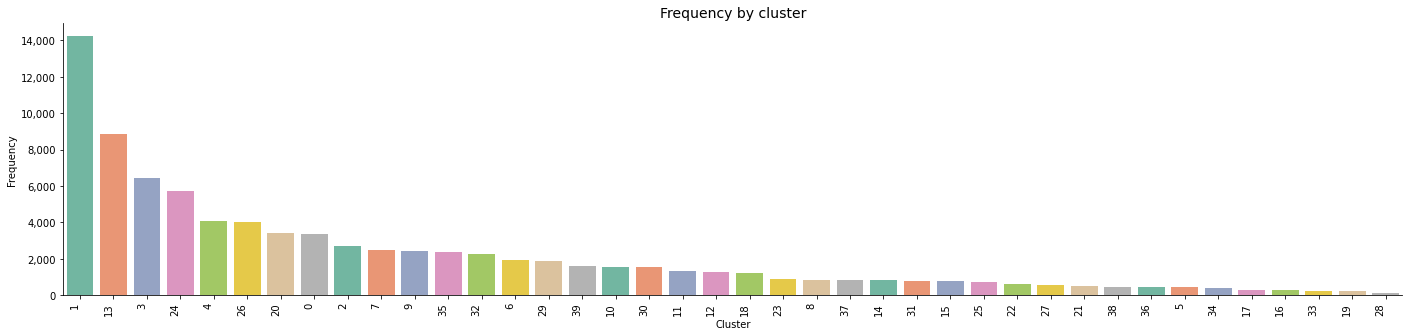

In [33]:
# Frequency by cluster

# Draw
fig, ax = plt.subplots(figsize=(24,5))
g = sns.countplot(x=ds['cluster'], data=ds, order=ds['cluster'].value_counts().index, palette="Set2")

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Frequency by cluster", fontsize=plots_Title_fontSize)
plt.xlabel("Cluster")
plt.ylabel("Frequency")
plt.rc('axes', labelsize=subPlots_label_fontSize)
plt.xticks(rotation=90, ha='right');

Frequency by country

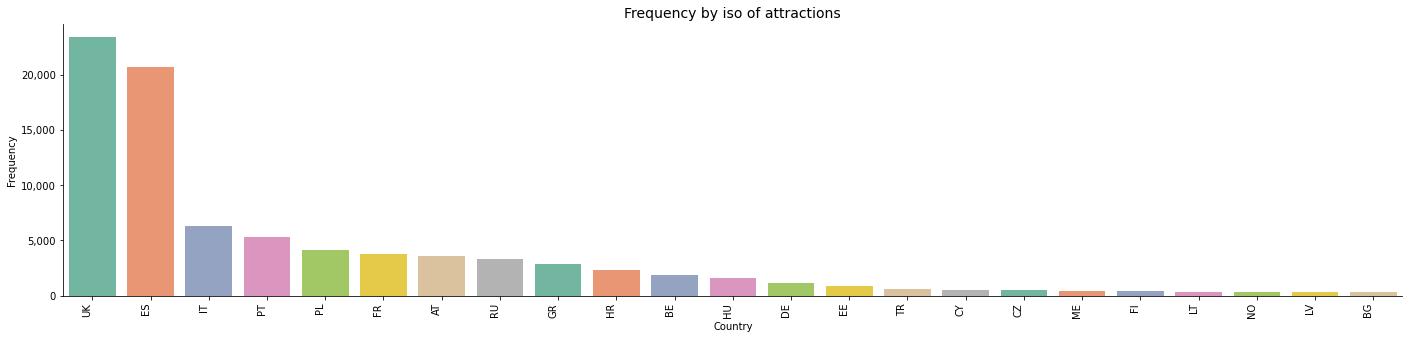

In [34]:
# Frequency by coutry

# Draw
fig, ax = plt.subplots(figsize=(24,5))
g = sns.countplot(x=ds['localISO'], data=ds, order=ds['localISO'].value_counts().index, palette="Set2")

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Frequency by iso of attractions", fontsize=plots_Title_fontSize)
plt.xlabel("Country")
plt.ylabel("Frequency")
plt.rc('axes', labelsize=subPlots_label_fontSize)
plt.xticks(rotation=90, ha='right');

Here we have the exact number of the amount of time that an attraction appear

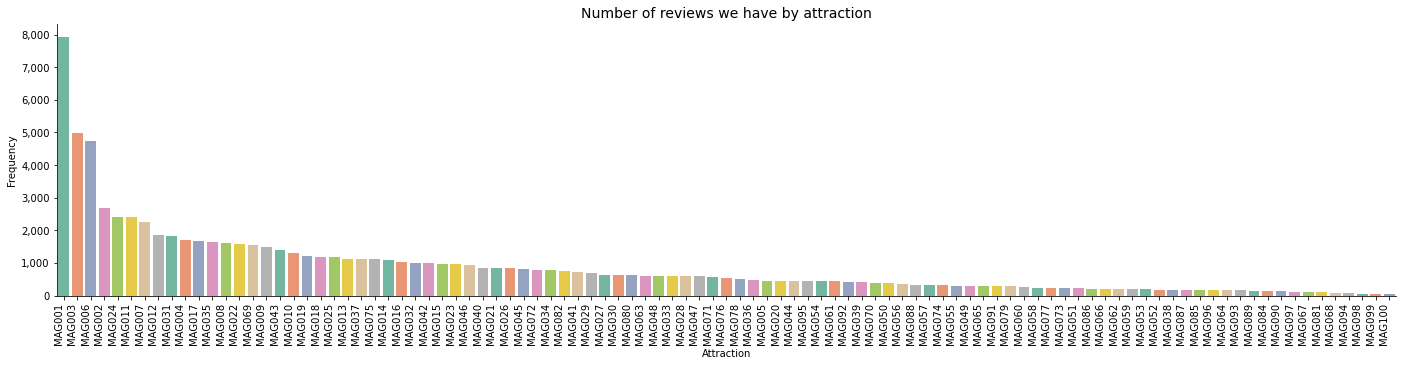

In [35]:
# Frequency by coutry

# Draw
fig, ax = plt.subplots(figsize=(24,5))
g = sns.countplot(x=ds['localID'], data=ds, order=ds['localID'].value_counts().index, palette="Set2")

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Number of reviews we have by attraction", fontsize=plots_Title_fontSize)
plt.xlabel("Attraction")
plt.ylabel("Frequency")
plt.rc('axes', labelsize=subPlots_label_fontSize)
plt.xticks(rotation=90, ha='right');

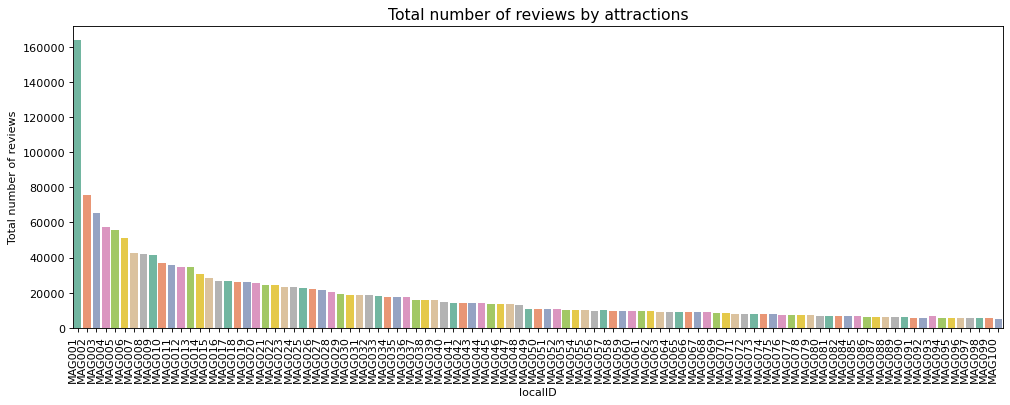

In [36]:
# draw a plot with seaborn as sns based on ratio column and with localISO as label
fig, ax = plt.subplots(figsize=(15,5), dpi= 80)

sns.barplot(y='totalReviews', x='localID', data=ds, palette="Set2", ax=ax)

plt.title('Total number of reviews by attractions', fontsize=plots_Title_fontSize)
plt.xlabel('localID')
plt.ylabel('Total number of reviews')
plt.xticks(rotation=90, ha='right');
plt.show()


### Here the number for the graph above

In [37]:
ds['cluster'].value_counts().head(30)

1     14231
13     8869
3      6462
24     5722
4      4046
26     3989
20     3388
0      3334
2      2685
7      2482
9      2409
35     2377
32     2257
6      1903
29     1887
39     1612
10     1567
30     1565
11     1300
12     1253
18     1202
23      878
8       833
37      813
14      812
31      779
15      761
25      705
22      620
27      528
Name: cluster, dtype: int64

In [38]:
ds['localISO'].value_counts().head(30)

UK    23430
ES    20680
IT     6293
PT     5289
PL     4147
FR     3749
AT     3596
RU     3315
GR     2858
HR     2273
BE     1903
HU     1565
DE     1137
EE      854
TR      594
CY      528
CZ      460
ME      412
FI      399
LT      338
NO      298
LV      282
BG      277
Name: localISO, dtype: int64

In [39]:
ds['localID'].value_counts().head(30)

MAG001    7935
MAG003    4988
MAG006    4728
MAG002    2672
MAG024    2422
MAG011    2409
MAG007    2260
MAG012    1848
MAG031    1827
MAG004    1706
MAG017    1679
MAG035    1637
MAG008    1612
MAG022    1575
MAG069    1546
MAG009    1492
MAG043    1388
MAG010    1297
MAG019    1218
MAG018    1184
MAG025    1181
MAG013    1121
MAG037    1121
MAG075    1115
MAG014    1100
MAG016    1043
MAG032    1007
MAG042     990
MAG015     980
MAG023     960
Name: localID, dtype: int64

Print a graph that show the number of reviews  

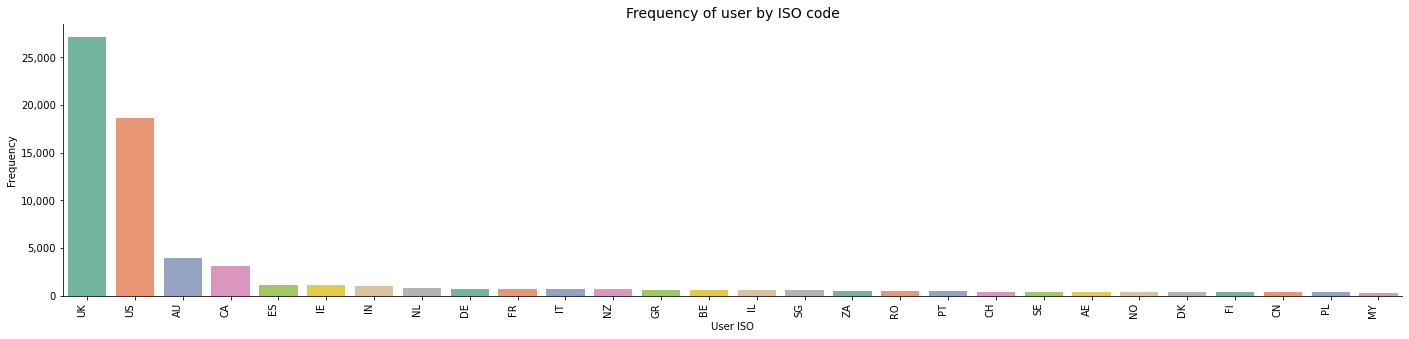

In [40]:
# Creating a subset of the data set with the most relevant values for this graph
userISO = ds.copy()
userISO['userISOFreq'] = userISO.groupby('userISO')['userISO'].transform('count') # we count how many users we have per country
userISO = userISO[userISO['userISOFreq'] > 250] # here we decide how many user we want to have per country

# Draw
fig, ax = plt.subplots(figsize=(24,5))
g = sns.countplot(x=userISO['userISO'], data=userISO, order=userISO['userISO'].value_counts().index, palette="Set2")

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Frequency of user by ISO code", fontsize=plots_Title_fontSize)
plt.xlabel("User ISO")
plt.ylabel("Frequency")
plt.rc('axes', labelsize=subPlots_label_fontSize)
plt.xticks(rotation=90, ha='right');

How many review we have per country

In [41]:
isoCompare = ds.groupby('userISO')['userISO'].count()
isoCompare = isoCompare.to_frame()
isoCompare = isoCompare.rename(columns={'userISO': 'iso'})
isoCompare.reset_index(inplace=True, level=['userISO'])
isoCompare.sort_values(by=['iso'], inplace=True, ascending=False)

isoCompare.head(20)

,userISO,iso
230,UK,27147
231,US,18640
11,AU,3984
41,CA,3047
71,ES,1084
102,IE,1064
105,IN,1009
164,NL,808
60,DE,737
78,FR,696


This show again how the dataset is biased and also the percentage of the total ammount of review that this dataset rappresent

In [42]:
# new dataset with rows grouped by localISO with attratctionFreq and totalReviews summed
reviewsToCompare = ds.drop_duplicates(subset=['localID'])

reviewsToCompare = reviewsToCompare.groupby('localISO').agg({'attractionFreq': 'sum', 'totalReviews': 'sum'}).reset_index()
reviewsToCompare['ratio'] = (reviewsToCompare['attractionFreq'] / reviewsToCompare['totalReviews']) * 100
reviewsToCompare[['localISO','ratio']].sort_values(by='ratio', ascending=False).head(30)

,localISO,ratio
22,UK,8.816325
11,HR,8.143743
16,ME,7.092443
12,HU,7.068654
3,CY,7.022210
10,GR,6.918757
18,PL,6.073521
6,EE,5.846112
14,LT,5.624896
17,NO,5.114124


We can see that this dataset is about 4.5% of reviews about this attractions of tripadvisor due to the fact that the language is English

In [43]:
reviewsToCompare.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
localISO,23,23,AT,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
attractionFreq,23.0,NaN,NaN,NaN,3681.608696,6069.997078,277.0,436.0,1565.0,3672.5,23430.0
totalReviews,23.0,NaN,NaN,NaN,79462.043478,119493.902259,5809.0,8829.0,30759.0,90173.0,528700.0
ratio,23.0,NaN,NaN,NaN,4.875175,1.988137,0.828217,3.495538,4.455955,6.496139,8.816325


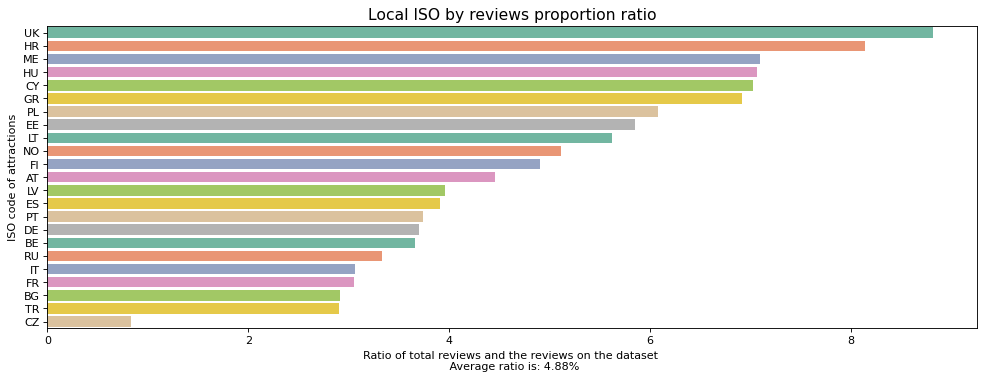

In [44]:
# draw a plot with seaborn as sns based on ratio column and with localISO as label
reviewsToCompare = reviewsToCompare.sort_values(by='ratio',ascending=False)

fig, ax = plt.subplots(figsize=(15,5), dpi= 80)

sns.barplot(x='ratio', y='localISO', data=reviewsToCompare, palette="Set2", ax=ax)

plt.title('Local ISO by reviews proportion ratio', fontsize=plots_Title_fontSize)
plt.xlabel('Ratio of total reviews and the reviews on the dataset \n Average ratio is: ' + str(round(reviewsToCompare['ratio'].mean(),2)) + '%')
plt.ylabel('ISO code of attractions')
plt.show()


We try to see if there is any correlation between userCotribution and userFreq

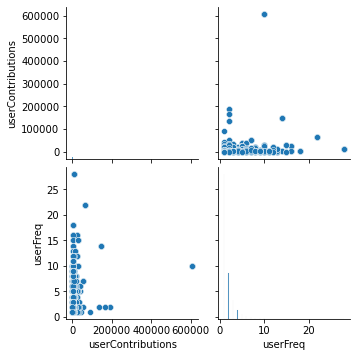

In [45]:
sns.pairplot(ds, vars=['userContributions','userFreq'], diag_kind="hist")

We tried to remove outliers in order to see how they effect the correlation with userFreq but in anycase they don't create a linear regession, so this data are not correlated

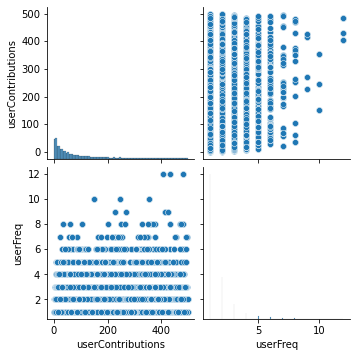

In [46]:
lowContribution = ds[ds['userContributions'] < 500]
sns.pairplot(lowContribution, vars=['userContributions','userFreq'], diag_kind="hist")

We have found a file with the percentage of visitor in portugal by country, so we tried to do the same statistic in order to see if at least reviews about portugal are biased or not.

In [47]:
# we try to perfom analysis on people who have visited portugal
dsPT = ds[ds["localISO"] == "PT"]

dsPT = dsPT.groupby('userISO')['userISO'].count() # I create a dataframe with the count of all the iso code in order to make a comparison, in this case they are only the review about portugal attractions
dsPT = dsPT.to_frame()
dsPT = dsPT.rename(columns={'userISO': 'iso'})
dsPT.reset_index(inplace=True, level=['userISO'])

dsSame = ds.groupby('userISO')['same_iso'].sum() # here we count how many users are in their country
dsSame = dsSame.to_frame()
dsSame.reset_index(inplace=True, level=['userISO'])

dsAbroad = isoCompare.merge(dsSame, on='userISO', how='inner') # We merge the dataframe created with this one
dsAbroad.sort_values('iso', inplace=True, ascending=False)
dsAbroad.head(30)

inner_join = pd.merge(dsPT, dsAbroad, on ='userISO',how ='inner', suffixes=('_pt', '_all')) # Here I make the ration between the review about portuguese attraction and the reviews made outside portugal not in the same country of the reviewer
inner_join['userAbroad'] = inner_join['iso_all'] - inner_join['same_iso'] # Here we count how many users per country goes abroad
inner_join['ratioPT_%'] = (inner_join['iso_pt'] / inner_join['userAbroad']) * 100 # Here we try to see the percentage between users abroad and the ones that goes in portugal
inner_join = inner_join[(inner_join['userISO'] == 'UK') | (inner_join['userISO'] == 'FR') | (inner_join['userISO'] == 'ES') | (inner_join['userISO'] == 'DE') | (inner_join['userISO'] == 'CH') | (inner_join['userISO'] == 'NL') | (inner_join['userISO'] == 'IT') | (inner_join['userISO'] == 'BE')] # Filtering only the countries finded on the business understading part
inner_join.sort_values(by=['ratioPT_%'], inplace=True, ascending=False)

inner_join.head(30)


,userISO,iso_pt,iso_all,same_iso,userAbroad,ratioPT_%
32,ES,73,1084,660,424,17.216981
11,BE,54,564,116,448,12.053571
51,IT,58,694,188,506,11.462451
75,NL,88,808,0,808,10.891089
37,FR,58,696,142,554,10.469314
25,DE,56,737,47,690,8.115942
105,UK,1143,27147,10771,16376,6.979726
18,CH,28,408,0,408,6.862745


In [48]:
before['localID'].value_counts().to_frame().head(10)

,localID
MAG001,7796
MAG003,4610
MAG006,4194
MAG002,2617
MAG011,2305
MAG007,2228
MAG024,1888
MAG012,1803
MAG031,1731
MAG017,1635


In [49]:
after['localID'].value_counts().to_frame().head(10) # the order is changed because people cannot travel during the corone and 1/3 of the dataset is made by english people

,localID
MAG024,534
MAG006,534
MAG043,406
MAG003,378
MAG075,328
MAG069,258
MAG035,210
MAG072,160
MAG080,144
MAG001,139


In the dataset before covid we have 93% of the observations 

In [50]:
(len(before.index)/len(ds.index)) * 100

93.29097629816833

Showing how many trip type we have before covid

In [51]:
before.info() # here we have 70% of triptype reviews

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78996 entries, 54 to 84676
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   localID            78996 non-null  object        
 1   globalRating       78996 non-null  float64       
 2   totalReviews       78996 non-null  int64         
 3   userName           78996 non-null  object        
 4   userLocation       67646 non-null  object        
 5   userContributions  78996 non-null  int64         
 6   tripType           55127 non-null  object        
 7   reviewWritten      78996 non-null  datetime64[ns]
 8   reviewVisited      78996 non-null  datetime64[ns]
 9   reviewRating       78996 non-null  int64         
 10  reviewFullText     78996 non-null  object        
 11  userISO            67620 non-null  object        
 12  localISO           78996 non-null  object        
 13  cluster            78996 non-null  int64         
 14  revie

TriptType percentage of the entire dataset

In [52]:
dsTypeNoNAN = ds.dropna(subset=['tripType'])
dsType = dsTypeNoNAN['tripType'].value_counts().head(20)
dsType = ((dsType / dsTypeNoNAN.shape[0]) * 100).to_frame()
dsType.reset_index(inplace=True)
dsType.head()

,index,tripType
0,Couples,50.328095
1,Family,21.453980
2,Friends,18.768779
3,Solo,8.093594
4,Business,1.355552


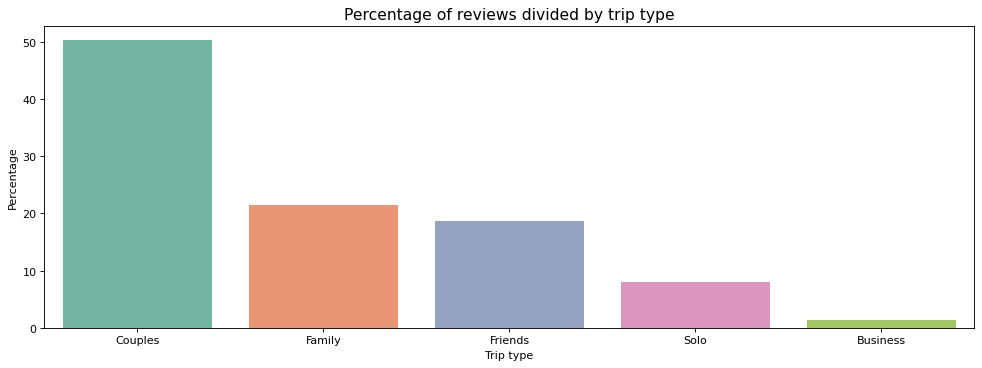

In [53]:
# draw a plot with seaborn as sns based on ratio column and with localISO as label

fig, ax = plt.subplots(figsize=(15,5), dpi= 80)

sns.barplot(x='index', y='tripType', data=dsType, palette="Set2", ax=ax)

plt.title('Percentage of reviews divided by trip type', fontsize=plots_Title_fontSize)
plt.xlabel('Trip type')
plt.ylabel('Percentage')
plt.show()

Trip type before covid

In [54]:
beforeTypeNoNAN = before.dropna(subset=['tripType'])
beforeType = beforeTypeNoNAN['tripType'].value_counts().head(20)
beforeType = ((beforeType / beforeTypeNoNAN.shape[0]) * 100).to_frame()
beforeType.reset_index(inplace=True)
beforeType.head()

,index,tripType
0,Couples,50.251238
1,Family,21.234604
2,Friends,19.030602
3,Solo,8.088595
4,Business,1.394961


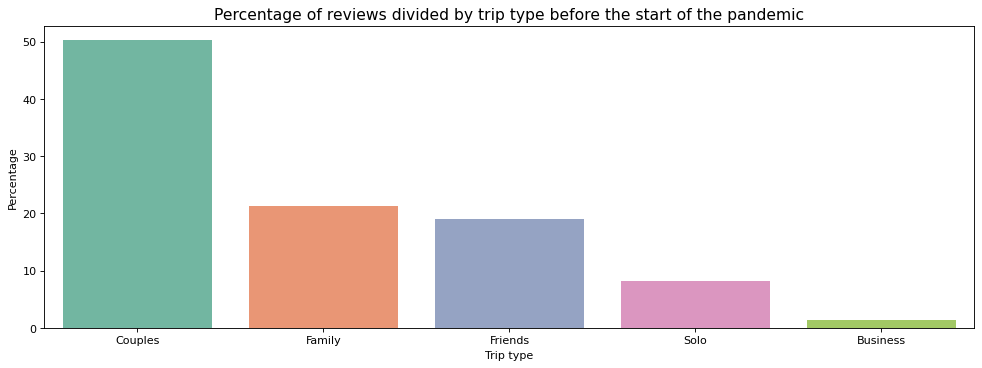

In [55]:
# draw a plot with seaborn as sns based on ratio column and with localISO as label

fig, ax = plt.subplots(figsize=(15,5), dpi= 80)

sns.barplot(x='index', y='tripType', data=beforeType, palette="Set2", ax=ax)

plt.title('Percentage of reviews divided by trip type before the start of the pandemic', fontsize=plots_Title_fontSize)
plt.xlabel('Trip type')
plt.ylabel('Percentage')
plt.show()

How many trip type we have on the after covid

In [56]:
after.info() # here we have 48% triptype reviews

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5681 entries, 0 to 84631
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   localID            5681 non-null   object        
 1   globalRating       5681 non-null   float64       
 2   totalReviews       5681 non-null   int64         
 3   userName           5681 non-null   object        
 4   userLocation       4644 non-null   object        
 5   userContributions  5681 non-null   int64         
 6   tripType           2783 non-null   object        
 7   reviewWritten      5681 non-null   datetime64[ns]
 8   reviewVisited      5044 non-null   datetime64[ns]
 9   reviewRating       5681 non-null   int64         
 10  reviewFullText     5681 non-null   object        
 11  userISO            4270 non-null   object        
 12  localISO           5681 non-null   object        
 13  cluster            5681 non-null   int64         
 14  reviewL

Trip type after covid

In [57]:
afterTypeNoNAN = after.dropna(subset=['tripType'])
afterType = afterTypeNoNAN['tripType'].value_counts().head(20)
afterType = ((afterType / afterTypeNoNAN.shape[0]) * 100).to_frame()
afterType.reset_index(inplace=True)
afterType.head()

,index,tripType
0,Couples,51.850521
1,Family,25.799497
2,Friends,13.582465
3,Solo,8.192598
4,Business,0.574919


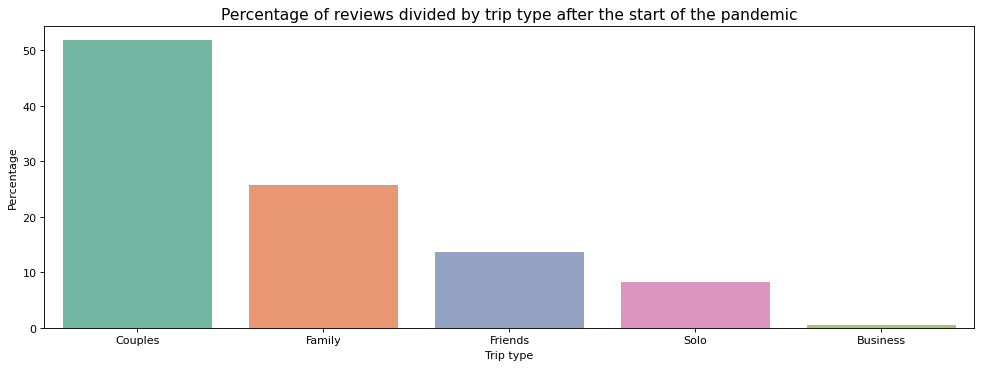

In [58]:
# draw a plot with seaborn as sns based on ratio column and with localISO as label

fig, ax = plt.subplots(figsize=(15,5), dpi= 80)

sns.barplot(x='index', y='tripType', data=afterType, palette="Set2", ax=ax)

plt.title('Percentage of reviews divided by trip type after the start of the pandemic', fontsize=plots_Title_fontSize)
plt.xlabel('Trip type')
plt.ylabel('Percentage')
plt.show()

Comparison between before and after the start of the pandemic

/home/tosk/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/tosk/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


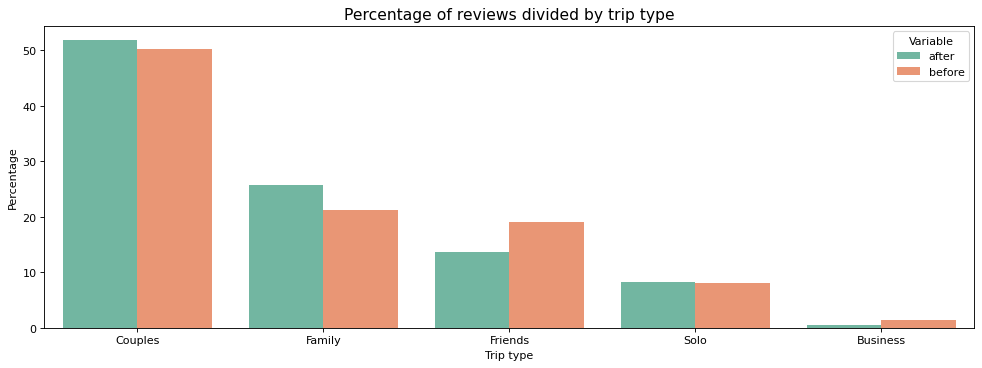

In [59]:
dsComparison = afterType.copy()
dsComparison['before'] = beforeType['tripType']
dsComparison.rename(columns={'tripType':'after'}, inplace=True)
dsComparison.rename(columns={'index':'tripType'}, inplace=True)
meltedComparison = dsComparison.melt(id_vars='tripType').rename(columns=str.title)

# draw a plot with seaborn as sns based on ratio column and with localISO as label

fig, ax = plt.subplots(figsize=(15,5), dpi= 80)

sns.barplot(x='Triptype', y='Value', data=meltedComparison, palette="Set2", ax=ax, hue='Variable')

plt.title('Percentage of reviews divided by trip type', fontsize=plots_Title_fontSize)
plt.xlabel('Trip type')
plt.ylabel('Percentage')
plt.show()

In [110]:
meltedComparison

,Triptype,Variable,Value
0,Couples,all_clusters,50.328095
1,Family,all_clusters,21.453980
2,Friends,all_clusters,18.768779
3,Solo,all_clusters,8.093594
4,Business,all_clusters,1.355552
5,Couples,Lisbon,53.910819
6,Family,Lisbon,19.261696
7,Friends,Lisbon,17.653509
8,Solo,Lisbon,8.442982
9,Business,Lisbon,0.730994


Length of review before and after covid, a little bit long on the after

In [60]:
before['reviewLength'].mean()

360.7937464396481

In [61]:
after['reviewLength'].mean()

389.60200668896323

In [62]:
before['reviewLength'].median()

255.0

In [63]:
after['reviewLength'].median()

268.0

Review score per trip type

In [64]:
ratingType = ds.groupby('tripType')['reviewRating'].mean()
ratingType.head()

tripType
Business    4.686624
Couples     4.566855
Family      4.539520
Friends     4.588371
Solo        4.585022
Name: reviewRating, dtype: float64

Trip type for cluster of Porto, if you change the cluster number will be another place

In [65]:
clusterType = ds[ds['cluster'] == 11].dropna(subset='tripType') # Here we can find for each cluster different type of trip
cluster11 = ((clusterType.groupby('tripType')['tripType'].count() / clusterType.shape[0]) * 100).to_frame()
cluster11.rename(columns={'tripType':'Porto'}, inplace=True)
cluster11.reset_index(inplace=True)
cluster11.sort_values(by='Porto', inplace=True, ascending=False, ignore_index=True)
cluster11.head()

,tripType,Porto
0,Couples,58.286359
1,Friends,16.685457
2,Family,13.754228
3,Solo,10.259301
4,Business,1.014656


/home/tosk/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/tosk/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


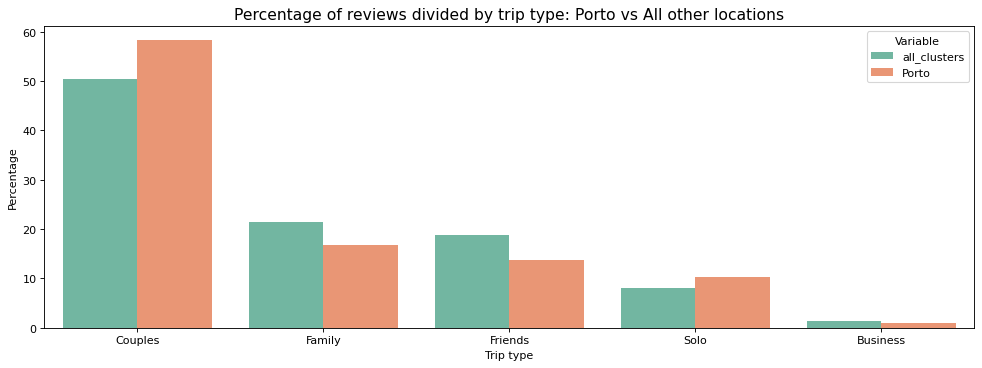

In [66]:
dsComparison = dsType.copy()
dsComparison['Porto'] = cluster11['Porto']
dsComparison.rename(columns={'tripType':'all_clusters'}, inplace=True)
dsComparison.rename(columns={'index':'tripType'}, inplace=True)
meltedComparison = dsComparison.melt(id_vars='tripType').rename(columns=str.title)

# draw a plot with seaborn as sns based on ratio column and with localISO as label

fig, ax = plt.subplots(figsize=(15,5), dpi= 80)

sns.barplot(x='Triptype', y='Value', data=meltedComparison, palette="Set2", ax=ax, hue='Variable')

plt.title('Percentage of reviews divided by trip type: Porto vs All other locations', fontsize=plots_Title_fontSize)
plt.xlabel('Trip type')
plt.ylabel('Percentage')
plt.show()

Trip type for cluster of Lisbon, if you change the cluster number will be another place

In [67]:
clusterType = ds[ds['cluster'] == 26].dropna(subset='tripType') # Here we can find for each cluster different type of trip
cluster26 = ((clusterType.groupby('tripType')['tripType'].count() / clusterType.shape[0]) * 100).to_frame()
cluster26.rename(columns={'tripType':'Lisbon'}, inplace=True)
cluster26.reset_index(inplace=True)
cluster26.sort_values(by='Lisbon', inplace=True, ascending=False, ignore_index=True)
cluster26.head()

,tripType,Lisbon
0,Couples,53.910819
1,Friends,19.261696
2,Family,17.653509
3,Solo,8.442982
4,Business,0.730994


/home/tosk/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/tosk/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


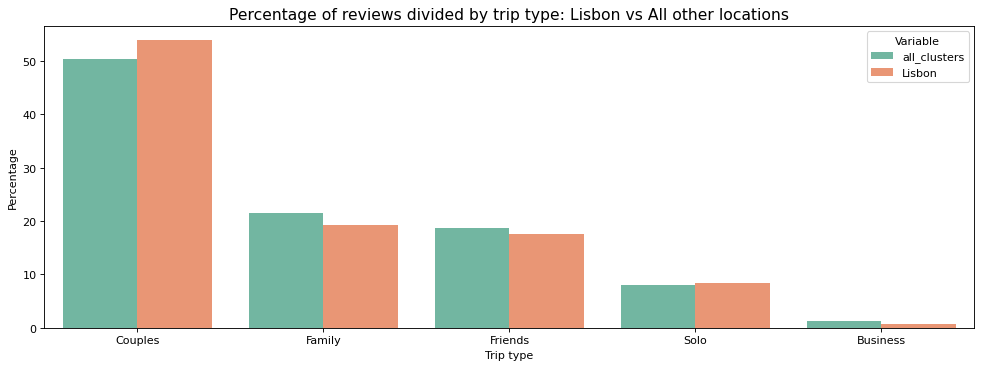

In [68]:
dsComparison = dsType.copy()
dsComparison['Lisbon'] = cluster26['Lisbon']
dsComparison.rename(columns={'tripType':'all_clusters'}, inplace=True)
dsComparison.rename(columns={'index':'tripType'}, inplace=True)
meltedComparison = dsComparison.melt(id_vars='tripType').rename(columns=str.title)

# draw a plot with seaborn as sns based on ratio column and with localISO as label

fig, ax = plt.subplots(figsize=(15,5), dpi= 80)

sns.barplot(x='Triptype', y='Value', data=meltedComparison, palette="Set2", ax=ax, hue='Variable')

plt.title('Percentage of reviews divided by trip type: Lisbon vs All other locations', fontsize=plots_Title_fontSize)
plt.xlabel('Trip type')
plt.ylabel('Percentage')
plt.show()

In [111]:
meltedComparison

,Triptype,Variable,Value
0,Couples,all_clusters,50.328095
1,Family,all_clusters,21.453980
2,Friends,all_clusters,18.768779
3,Solo,all_clusters,8.093594
4,Business,all_clusters,1.355552
5,Couples,Lisbon,53.910819
6,Family,Lisbon,19.261696
7,Friends,Lisbon,17.653509
8,Solo,Lisbon,8.442982
9,Business,Lisbon,0.730994


See how many people leave the country before the covid

In [69]:
AttractionCountry = before[before['attractionCountry'] == True]  # here we find only people that live in countries where there are attractions, because we cannot know if us people have putted review on the us
ratioBefore = AttractionCountry.groupby('same_iso')['same_iso'].count()
ratioBefore = ratioBefore.to_frame()
ratioBefore['same_iso_%'] = (ratioBefore['same_iso'] / AttractionCountry.shape[0]) * 100

ratioBefore.rename(columns={'same_iso':'sum'}, inplace=True)
ratioBefore.reset_index(inplace=True)
ratioBefore.head()

,same_iso,sum,same_iso_%
0,False,21058,67.127829
1,True,10312,32.872171


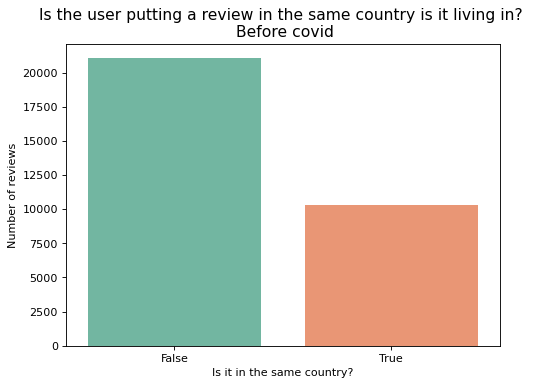

In [70]:
fig, ax = plt.subplots(figsize=(7,5), dpi= 80)

sns.barplot(x='same_iso', y='sum', data=ratioBefore, palette="Set2", ax=ax)

plt.title('Is the user putting a review in the same country is it living in? \n Before covid', fontsize=plots_Title_fontSize)
plt.xlabel('Is it in the same country?')
plt.ylabel('Number of reviews')
plt.show()


How many people leave the country after the covid

In [71]:
AttractionCountry = after[after['attractionCountry'] == True] # here we find only people that live in countries where there are attractions, because we cannot know if us people have putted review on the us
ratioAfter = AttractionCountry.groupby('same_iso')['same_iso'].count()
ratioAfter = ratioAfter.to_frame()
ratioAfter['same_iso_%'] = (ratioAfter['same_iso'] / AttractionCountry.shape[0]) * 100

ratioAfter.rename(columns={'same_iso':'sum'}, inplace=True)
ratioAfter.reset_index(inplace=True)
ratioAfter.head()

,same_iso,sum,same_iso_%
0,False,911,26.474862
1,True,2530,73.525138


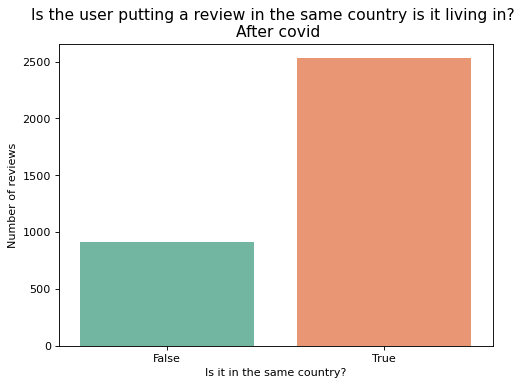

In [72]:
fig, ax = plt.subplots(figsize=(7,5), dpi= 80)

sns.barplot(x='same_iso', y='sum', data=ratioAfter, palette="Set2", ax=ax)

plt.title('Is the user putting a review in the same country is it living in? \n After covid', fontsize=plots_Title_fontSize)
plt.xlabel('Is it in the same country?')
plt.ylabel('Number of reviews')
plt.show()


Length of reviews in the holiday

In [73]:
hodidayReviews = ds.groupby('holiday')['reviewLength'].mean()
hodidayReviews.head()

holiday
False    362.972170
True     360.041702
Name: reviewLength, dtype: float64

Rating comaparison holiday or not

In [74]:
holidayRating = ds.groupby('holiday')['reviewRating'].mean()
holidayRating.head()

holiday
False    4.574202
True     4.613835
Name: reviewRating, dtype: float64

The problem here is that we have marked as holiday dates that are within three days of an holiday (where is holiday in the same country of the user), but for example in some countries a lot of people goes in holiday in august because office are closed and we are not measuring this data. Then some coutries like France for example have holiday after a fixed amount of weeks, also this is not measured. But without this data we can only say that the holiday dataset isn't enough.

With this two pieces of code we want to see if there a difference between after and before talking about when people prefer to travel

In [75]:
ratioBefore = before.groupby('holiday')['holiday'].count()

print((ratioBefore / before.shape[0]) * 100)

holiday
False    91.262849
True      8.737151
Name: holiday, dtype: float64


In [76]:
ratioAfter = after.groupby('holiday')['holiday'].count()

print((ratioAfter / after.shape[0]) * 100)

holiday
False    96.549903
True      3.450097
Name: holiday, dtype: float64


Trip type during holiday

In [77]:
holidayType = ds[ds['holiday'] == True].dropna(subset='tripType')
numberOfRows = holidayType.shape[0]
holidayType = holidayType.groupby('tripType')['tripType'].count()

print((holidayType / numberOfRows) * 100)

tripType
Business     1.090209
Couples     46.130825
Family      25.416845
Friends     18.790081
Solo         8.572039
Name: tripType, dtype: float64


Trip type during the rest of the year

In [78]:
holidayType = ds[ds['holiday'] == False].dropna(subset='tripType')
numberOfRows = holidayType.shape[0]
holidayType = holidayType.groupby('tripType')['tripType'].count()

print((holidayType / numberOfRows) * 100)

tripType
Business     1.378870
Couples     50.696949
Family      21.105726
Friends     18.766907
Solo         8.051548
Name: tripType, dtype: float64


# Apriori 

Here because we have overrepresented countries like the UK and underrepresented countries like Italy we have a big problem of biases. Because that thing means that the support will not be the same as in the real world, it will be bigger or smaller. 

Anyway since these are the data that we have we tried our best to address this problem and we decided to only use data of people with at least 7 reviews. This is better because the higher the number of reviews per user, the better apriori will work but it will introduce bias as well.

But we decided that 7 is a good number because the lift between countries is supposed to be around 1 because saying that if you go to Spain then you will not go to another place within three years makes any sense. Make sense if you are talking only about on singular trip but not if you are talking about three years. So based on that, we decided to choose 7.

In [79]:
dsMoreThan = ds[ds['userFreq'] > 7] # we decided how many review per person we should have based on the lift, because having high or low lift for iso or cluster make no sense
#dsMoreThan = ds[(ds['userFreq'] > 7) & (ds['same_iso'] == False)] # We made this filter because we see that Spain was always the most similar, so maybe removing Spanish reviews made by Spanish people can change something, but was not working
dsMoreThan.describe(include='all', datetime_is_numeric=True).T # we can see how many data we are keeping

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
localID,1257,98,MAG001,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
globalRating,1257.0,NaN,NaN,NaN,4.496818,4.0,4.5,4.5,4.5,5.0,0.204424
totalReviews,1257.0,NaN,NaN,NaN,30141.653938,5179.0,10250.0,19017.0,34703.0,163828.0,33694.873552
userName,1257,130,Malgorzata@Margo7850p,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userLocation,1197,108,"London, UK",56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userContributions,1257.0,NaN,NaN,NaN,11326.719968,35.0,593.0,1456.0,4550.0,607732.0,56355.971775
tripType,743,5,Couples,356,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reviewWritten,1257,NaN,NaN,NaN,2019-10-23 18:40:22.911694592,2019-01-01 00:00:00,2019-06-05 00:00:00,2019-09-11 00:00:00,2020-01-03 00:00:00,2021-08-20 00:00:00,NaN
reviewVisited,1254,NaN,NaN,NaN,2019-07-26 00:05:44.497607680,2018-02-01 00:00:00,2019-04-01 00:00:00,2019-07-01 00:00:00,2019-10-01 00:00:00,2021-08-01 00:00:00,NaN
reviewRating,1257.0,NaN,NaN,NaN,4.659507,1.0,4.0,5.0,5.0,5.0,0.582569


The apriori based on localID is usefull to see which are the locations visited togheter, this result explain why we decided to create clusters. And thats because people that visit one city goes to visit more than one attraction, but since we don't have reviews for all the places visited but only for the places where poeple write a review a cluster make more sense.

In [80]:
# Create a pivot table
pt = pd.pivot_table(dsMoreThan[['userName','localID']],
                    index='userName',                                  # Each row will be a document (invoice)
                    columns='localID',                       # Each product will be a column
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)   # The value should be 1 if the product is present in the document, otherwise 0

frequent_itemsets = apriori(pt.astype('bool'), min_support=0.01, use_colnames=True)

# Generate the association rules - by support
rulesSupport = association_rules(frequent_itemsets, metric="support", min_threshold=0.2) # with support 0.1 you find the one with higher support using two reviews per user
rulesSupport.sort_values(by='confidence', ascending=False, inplace=True) # sorted by confidence in order to know which are the location visited toghter whit higher chance
rulesSupport.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(MAG004),(MAG001),0.246154,0.407692,0.230769,0.937500,2.299528,0.130414,9.476923
4,(MAG023),(MAG001),0.238462,0.407692,0.207692,0.870968,2.136336,0.110473,4.590385
1,(MAG002),(MAG001),0.292308,0.407692,0.246154,0.842105,2.065541,0.126982,3.751282
0,(MAG001),(MAG002),0.407692,0.292308,0.246154,0.603774,2.065541,0.126982,1.786081
3,(MAG001),(MAG004),0.407692,0.246154,0.230769,0.566038,2.299528,0.130414,1.737124
5,(MAG001),(MAG023),0.407692,0.238462,0.207692,0.509434,2.136336,0.110473,1.552367


This analysis can be useful to discover who are the competitors of Portugal.

We also use this analysis in order to decide the threshold of number of reviews. In order to do that we started to choose a different number of reviews per user, and we discovered that over 7 reviews per user the lift start to be near to 1 which is what we expect to see. We also know that more reviews per user meaning a better apriori result, so we decided based on that to choose 7 as the number of reviews per user.

In [81]:
# Create a pivot table
ptISO = pd.pivot_table(dsMoreThan[['userName','localISO']],
                    index='userName',                                  # Each row will be a document (invoice)
                    columns='localISO',                       # Each product will be a column
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)   # The value should be 1 if the product is present in the document, otherwise 0

frequent_itemsetsISO = apriori(ptISO.astype('bool'), min_support=0.01, use_colnames=True)

# Generate the association rules - by support
rulesSupportISO = association_rules(frequent_itemsetsISO, metric="support", min_threshold=0.11) 
rulesSupportISO.sort_values(by='confidence', ascending=False, inplace=True)
rulesSupportISO.head(200)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(PT),(ES),0.361538,0.607692,0.284615,0.787234,1.295448,0.064911,1.843846
0,(FR),(ES),0.276923,0.607692,0.153846,0.555556,0.914205,-0.014438,0.882692
3,(IT),(ES),0.369231,0.607692,0.200000,0.541667,0.891350,-0.024379,0.855944
12,(PL),(IT),0.215385,0.369231,0.115385,0.535714,1.450893,0.035858,1.358580
10,(FR),(UK),0.276923,0.438462,0.146154,0.527778,1.203704,0.024734,1.189140
8,(FR),(IT),0.276923,0.369231,0.146154,0.527778,1.429398,0.043905,1.335747
7,(UK),(ES),0.438462,0.607692,0.230769,0.526316,0.866089,-0.035680,0.828205
15,(IT),(UK),0.369231,0.438462,0.184615,0.500000,1.140351,0.022722,1.123077
5,(ES),(PT),0.607692,0.361538,0.284615,0.468354,1.295448,0.064911,1.200916
14,(UK),(IT),0.438462,0.369231,0.184615,0.421053,1.140351,0.022722,1.089510


This show that people that goes in one cluster goes also in a nearest cluster, which was expected becuase is more easier that nearest cities will be visited by the same people in one holiday than visiting different cities which are far away.

In [82]:
# Create a pivot table
ptCluster = pd.pivot_table(dsMoreThan[['userName','cluster']],
                    index='userName',                                  # Each row will be a document (invoice)
                    columns='cluster',                       # Each product will be a column
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)   # The value should be 1 if the product is present in the document, otherwise 0

frequent_itemsetsCluster = apriori(ptCluster.astype('bool'), min_support=0.01, use_colnames=True)

# Generate the association rules - by support
rulesSupportCluster = association_rules(frequent_itemsetsCluster, metric="support", min_threshold=0.2) # 0.05 is the highest support
rulesSupportCluster.sort_values(by='confidence', ascending=False, inplace=True)
rulesSupportCluster.head(200)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(4),(1),0.292308,0.515385,0.223077,0.763158,1.480754,0.072426,2.046154
3,(26),(1),0.323077,0.515385,0.215385,0.666667,1.293532,0.048876,1.453846
0,(1),(4),0.515385,0.292308,0.223077,0.432836,1.480754,0.072426,1.247773
2,(1),(26),0.515385,0.323077,0.215385,0.417910,1.293532,0.048876,1.162919


# Data similarity

Here we keep more than 2 reviews per user because since we are using rating we don't need to have a huge number of reviews in order to have a good accuracy.

In [83]:
dsMoreThan = ds[ds['userFreq'] > 2] # we use at least 3 reviews because centered cosine works better with 3
#dsMoreThan = ds[(ds['userFreq'] > 2) & (ds['same_iso'] == False)] # We made this filter because we see that Spain was always the most similar, so maybe removing Spanish reviews made by Spanish people can change something, but was not working
dsMoreThan.describe(include='all', datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
localID,14699,99,MAG001,1178,NaN,NaN,NaN,NaN,NaN,NaN,NaN
globalRating,14699.0,NaN,NaN,NaN,4.482074,4.0,4.5,4.5,4.5,5.0,0.208348
totalReviews,14699.0,NaN,NaN,NaN,38582.358528,5179.0,14132.0,23293.0,42555.0,163828.0,41397.583936
userName,14699,3816,Malgorzata@Margo7850p,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userLocation,13582,1772,"London, UK",562,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userContributions,14699.0,NaN,NaN,NaN,1827.953942,3.0,107.0,324.0,931.0,607732.0,16929.743195
tripType,9573,5,Couples,4957,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reviewWritten,14699,NaN,NaN,NaN,2019-09-02 07:39:33.467582976,2019-01-01 00:00:00,2019-05-18 00:00:00,2019-08-10 00:00:00,2019-11-04 00:00:00,2021-08-20 00:00:00,NaN
reviewVisited,14606,NaN,NaN,NaN,2019-07-06 11:18:11.880049152,2017-05-01 00:00:00,2019-04-01 00:00:00,2019-07-01 00:00:00,2019-10-01 00:00:00,2021-08-01 00:00:00,NaN
reviewRating,14699.0,NaN,NaN,NaN,4.619974,1.0,4.0,5.0,5.0,5.0,0.65559


# Similarity between attractions

This are attractions that are similar based on the difference of rating bewteen attraction per each user.

These numbers are near to zero not because they are dissimilar, but because we have in average 4,5 reviews per user and we are supposed to have something near to 99 which is the number of attractions that we have. So with the small numbers we have to look to the one that are positive or negative.

In [84]:
# Create a pivot table
pt = pd.pivot_table(dsMoreThan[['userName','localID','diffAvgRating']],
                    index='userName',                                  # Each row will be a user
                    columns='localID',                       # Each product will be a column
                    values='diffAvgRating',                                     # The value will be the rating for the localID
                    aggfunc='mean').fillna(0)   # The mean rating will be used if multiple ratings exist for the same user and localID

user_similarity_matrix = pd.DataFrame(
    pairwise_distances(pt,metric='cosine'),
    columns = pt.index,
    index = pt.index,
)
user_similarity_matrix = user_similarity_matrix.apply(lambda x: 1-x, axis=1) # Transform dissimilarity to similarity
user_similarity_matrix

# Similiar products matrix
localID_similarity = pd.DataFrame(
    pairwise_distances(pt.T,metric='cosine'),
    columns = pt.columns,
    index = pt.columns
    )
localID_similarity = localID_similarity.apply(lambda x: 1-x, axis=1) # Transform dissimilarity to similarity
localID_similarity

localID,MAG001,MAG002,MAG003,MAG004,MAG005,MAG006,MAG007,MAG008,MAG009,MAG010,...,MAG091,MAG092,MAG093,MAG094,MAG095,MAG096,MAG097,MAG098,MAG099,MAG100
localID,,,,,,,,,,,,,,,,,,,,,
MAG001,1.000000,-0.396966,-0.010942,-0.239067,-0.005289,-0.008789,-0.010249,0.028053,0.005709,-0.047468,...,-0.000074,-0.012440,0.001127,0.000040,-0.009415,-0.013219,-0.034514,0.020302,0.0,0.017838
MAG002,-0.396966,1.000000,-0.010409,-0.229960,-0.003534,-0.022747,-0.010070,-0.040026,-0.003789,-0.009689,...,-0.004919,-0.004934,-0.005215,0.023876,0.005646,-0.001514,-0.009328,-0.007369,0.0,-0.007057
MAG003,-0.010942,-0.010409,1.000000,-0.014241,0.003750,-0.085364,-0.029534,-0.001705,0.011791,-0.010796,...,-0.019273,-0.019442,0.002902,0.000076,0.011382,-0.007115,0.000000,0.000000,0.0,0.000000
MAG004,-0.239067,-0.229960,-0.014241,1.000000,0.002105,-0.010911,0.002350,-0.060030,-0.022189,-0.012801,...,-0.018141,0.005897,-0.001762,0.000046,0.000000,-0.010010,-0.026135,0.002968,0.0,0.017343
MAG005,-0.005289,-0.003534,0.003750,0.002105,1.000000,-0.008587,-0.150050,0.000284,-0.022787,0.004283,...,0.000000,0.000000,-0.017814,0.000000,0.000000,-0.009692,0.000000,0.012803,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAG096,-0.013219,-0.001514,-0.007115,-0.010010,-0.009692,0.009407,-0.006799,0.006992,-0.108941,0.000000,...,0.000000,-0.015558,0.000000,0.000000,0.000000,1.000000,-0.020187,0.000000,0.0,-0.053345
MAG097,-0.034514,-0.009328,0.000000,-0.026135,0.000000,-0.002570,0.000000,-0.014744,0.000000,0.037864,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.020187,1.000000,0.008533,0.0,-0.057456
MAG098,0.020302,-0.007369,0.000000,0.002968,0.012803,0.000000,0.009580,-0.008920,0.011189,-0.108945,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008533,1.000000,0.0,0.164803


In [85]:
# Here we can print the top 10 similar attraction of the one selected
top_10_similar_items = list(
    localID_similarity
        .loc['MAG010']
        .sort_values(ascending=False)
        .iloc[1:11]         # 1 to 11 instead of 0 to 10 because the first is the location itself
    .index
)
top_10_similar_items

['MAG097',
 'MAG085',
 'MAG080',
 'MAG081',
 'MAG050',
 'MAG043',
 'MAG028',
 'MAG023',
 'MAG072',
 'MAG091']

We print the excel file in oder to see how big is the similarity between different attraction, because the top 10 is fine but with some setting can give as a result some values with similarity as 0.

In [86]:
localID_similarity_excel = localID_similarity.copy()

localID_similarity_excel.reset_index(inplace=True, level=['localID'])
localID_similarity_excel.to_excel('localID_similarity.xlsx', index=False, sheet_name='Reviews')

print(datetime.datetime.now())

2023-01-25 18:16:06.519373


We haven't done the similarity between clusters and countries because the score is about the single attraction, and not clusters or countries.

We haven't done the dice because it look on what we have in different basket in order to do the similarity, but since we have too many users that didn't put reviews in all places where they go it will be not as much accurate. Is bettere che cosine which also uses the score give for each attraction.

# Creating RFM

In [87]:
RFM = ds[['userName','userFreq','reviewRating','userContributions', 'userISO']].copy()

We transformed the outliers that are higher then 500 to 500 in order to not have to hard code this values because of outliers. This will not be a problem for the analysis it self because we are looking to who publish the most so knowing that these people publish 500 or more content is enough. Another advantage is that later we can visualise the result, with the outlier this is a problem. 

In [88]:
RFM['userContributions'] = np.where(RFM['userContributions'] > 500, 500, RFM['userContributions'])

Some have a wrong user contribution, but since user contribution is reviews plus other type of contribution we will put the number of review that we have.

In [89]:
RFM['userContributions'] = np.where(RFM['userContributions'] == 0, RFM['userFreq'], RFM['userContributions'])

## Modeling

In [90]:
# Compute totals per customer
#dateMax = ds.recency.max()
X = RFM.groupby(['userName']).agg(Contributions=('userContributions', 'max'),
                                   Reviews=('userFreq', 'max'),
                                   Rating=('reviewRating', 'mean')).fillna(0)

This statistics are useful in other to better understand the data and decide which stategy to use with RFM.

In [91]:
# Determinining RFM cutting points based on the quartiles (default for pandas "describe")
cols = ['Contributions','Reviews','Rating']
table = X[cols].describe()
table

,Contributions,Reviews,Rating
count,65429.000000,65429.000000,65429.000000
mean,115.963992,1.294181,4.568047
std,147.794942,0.810682,0.799034
min,1.000000,1.000000,1.000000
25%,15.000000,1.000000,4.000000
50%,50.000000,1.000000,5.000000
75%,149.000000,1.000000,5.000000
max,500.000000,28.000000,5.000000


Since our dataset is about the most liked attractions is normal to have a lot of higher rating, so we can't use quartiles in order to segment the data because of the distribution of the rating. So we decided to hard code this numbers starting for the highest and decreasing with the smallest step as possible, so people that have an average under 3.5 will be on the first segment. Which is not a problem because they are not too many and also our analysis is about finding the highest score as possible.

For the number of reviews we have done the same, since the majority of the people have 1 reviews in our dataset.

In [92]:
# Calculate RMF scores

firstQuantile = X.quantile(0.25)['Contributions']
secondQuantile = X.quantile(0.5)['Contributions']
thridQuantile = X.quantile(0.75)['Contributions']

# this function is for userContributions
def RFMScore(x):
    if x <= firstQuantile:
        return '1'
    elif x <= secondQuantile:
        return '2'
    elif x <= thridQuantile:
        return '3'
    else:
        return '4'

# this function is for Rating values are below 3.5, above 3.5, above 4 and above 4.5
def MScore(x):
    if x <= 3.5:
        return '1'
    elif x <= 4:
        return '2'
    elif x <= 4.5:
        return '3'
    else:
        return '4'

# this function is for review frequency values are below 2, above 2, above 4 and above 6
def FScore(x):
    if x <= 2:
        return '1'
    elif x <= 4:
        return '2'
    elif x <= 6:
        return '3'
    else:
        return '4'

# Process
X['RScore'] = X['Contributions'].apply(RFMScore)
X['FScore'] = X['Reviews'].apply(FScore)
X['MScore'] = X['Rating'].apply(MScore)

## Evaluation

Here we can see that not all the segment are there,for example 14x is missing but is not a problem since we just want to select the more active one that are 444 in our case.

In [93]:
# Create a column with full RMF score and sort the results

# Transform to string
cols = ['RScore','FScore','MScore']
X[cols] = X[cols].astype(str)

# Concatenate
X['RFMScore'] = X['RScore'] + X['FScore'] + X['MScore']

# Sort
X = X.sort_values(by=['RFMScore'])

In [94]:
# Calculate statistics per RFM segment
RFMStats = X.reset_index().groupby(['RFMScore']).agg(NrCustomers=('userName', lambda i: len(i.unique())),
                                                     avgContributions=('Contributions', 'mean'),
                                                     avgReviews=('Reviews', 'mean'),
                                                     avgRating=('Rating', 'mean')).fillna(0)

In [95]:
# Show statistics
RFMStats

,NrCustomers,avgContributions,avgReviews,avgRating
RFMScore,,,,
111,1945,6.279692,1.045758,2.181748
112,2351,7.692897,1.046789,4.000000
113,189,9.724868,2.000000,4.500000
114,11771,7.302693,1.048934,5.000000
121,8,10.500000,3.000000,2.875000
122,17,10.529412,3.058824,3.862745
123,27,9.962963,3.222222,4.333333
124,101,9.861386,3.118812,4.869637
134,3,10.666667,5.000000,4.866667


Here you visualise the result, and that's why we choose to change the outliers values otherwise it will not be possible to have nice reppresentation. And again is important to remember that more than 500 contributions is fine for us, because of curse fitting the data in to the visualization that we want in not the best prectice almost all of the time.

/home/tosk/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/tosk/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


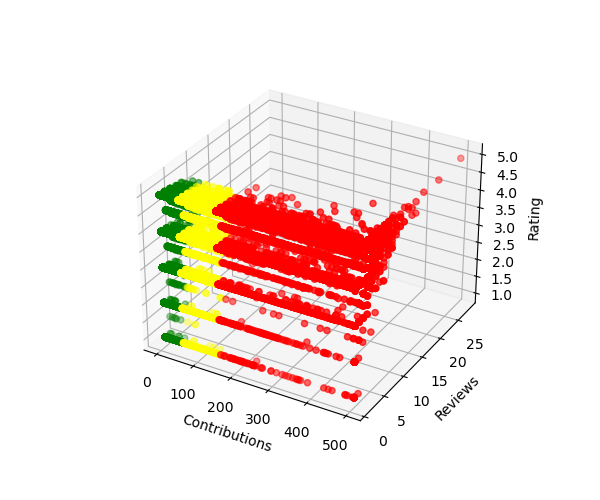

In [96]:
# Interactive 3D scatter plot of each customer's RFM values
%matplotlib widget

# Draw
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection = '3d')

# Decoration
ax.set_xlabel("Contributions")
ax.set_ylabel("Reviews")
ax.set_zlabel("Rating")

# Define color according to Recency (1 and 2:Green, 3:Yellow, 4:Red)
color = ['green' if x[0]<'3' else ('yellow' if x[0]=='3' else 'red') for x in X['RFMScore']]

# Plot
ax.scatter(X['Contributions'], X['Reviews'], X['Rating'], c=color)
plt.show()

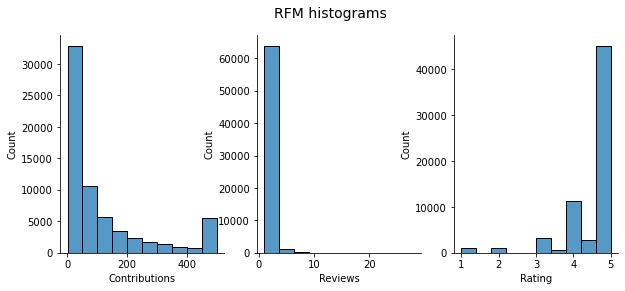

In [97]:
# Histogram of RFM
%matplotlib inline
cols = ['Contributions','Reviews','Rating']

# Draw
fig, ax = plt.subplots(1, 3, figsize=(10,4))
for var, subplot in zip(X[cols], ax.flatten()):
    g = sns.histplot(data=X,
                bins=10,
                 x=var,
                 ax=subplot,
                 kde=False)

# Decoration
sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("RFM histograms", fontsize=plots_Title_fontSize);

This graph suggest that the higher is the number of contributions and the lower it will be the rating.

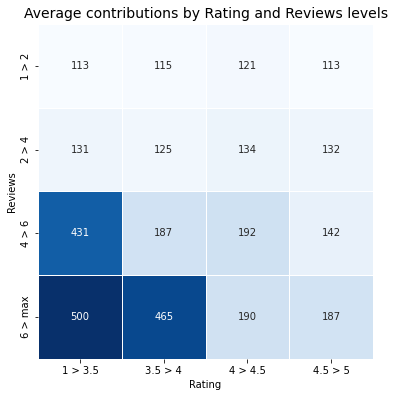

In [114]:
# RFM Heatmap

# Prepare data
tempDF = RFMStats
tempDF['Reviews'] = tempDF.index.str[1]
tempDF['Rating'] = tempDF.index.str[2]
pt = pd.pivot_table(tempDF, values='avgContributions', 
                     index=['Reviews'], 
                     columns='Rating')

# Draw
fig , ax = plt.subplots(figsize=(6, 8))
heatmap = sns.heatmap(pt,
                      square = True,
                      linewidths = .5,
                      cmap = 'Blues',
                      cbar=False,
                      fmt='.0f',
                      annot = True,
                      annot_kws = {'size': heatmaps_text_fontSize+2},
                        xticklabels = ["1 > 3.5","3.5 > 4","4 > 4.5","4.5 > 5"],
                     yticklabels = ["1 > 2","2 > 4","4 > 6","6 > max"])

# Decoration
plt.title("Average contributions by Rating and Reviews levels", fontsize=plots_Title_fontSize)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

# RFM segmented by countries

We print results in excel in order to have something to deliver to marketers.

In [99]:
# Copy the remaining variables to the modeling dataset (in this case is only the country)
# In case one of the country does not exist we're not taking in concideration
cols = ['userName','userISO']
X = X.merge(ds[cols], how='left', left_index=True, right_on='userName').drop(columns='userName')

In [100]:
# Encode categorical variables to dummy variables
# For more information the different methods to enconde categorical variables check https://contrib.scikit-learn.org/category_encoders/
cols = ['userISO' ]
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

In [101]:
# Create a copy of the dataset just with the columns to analyze
X_analysis = X.drop(columns=['RScore','FScore','MScore','RFMScore'])

In [102]:
# Check the mean values of each segment
segmentsMeanDF = pd.DataFrame(X_analysis.groupby(X['RFMScore'].values).mean())
segmentsMeanDF.transpose()

,111,112,113,114,121,122,123,124,134,211,...,423,424,431,432,433,434,441,442,443,444
Contributions,6.413471,7.766355,9.724868,7.382846,10.500,10.500000,10.080460,9.895238,10.666667,30.383923,...,396.457389,390.713076,432.10,430.303665,433.286252,422.800140,500.0,463.295455,473.549738,461.081121
Reviews,1.087512,1.089395,2.000000,1.093302,3.000,3.076923,3.275862,3.152381,5.000000,1.189562,...,3.509773,3.369508,5.75,5.345550,5.519774,5.423480,8.0,7.363636,8.486911,9.737463
Rating,2.221731,4.000000,4.500000,5.000000,2.875,3.865385,4.333333,4.869841,4.866667,2.544691,...,4.370602,4.876390,3.10,3.879581,4.342750,4.855346,3.5,3.886364,4.345550,4.811209
userISO_nan,0.462635,0.399025,0.402116,0.399368,0.250,0.423077,0.390805,0.380952,0.333333,0.180564,...,0.048475,0.020646,0.15,0.026178,0.043315,0.036338,0.0,0.079545,0.057592,0.074484
userISO_US,0.092920,0.111743,0.158730,0.161497,0.375,0.057692,0.252874,0.225397,0.666667,0.139172,...,0.273651,0.318687,0.00,0.277487,0.233522,0.292802,0.0,0.488636,0.327225,0.294985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
userISO_SM,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
userISO_Chcago,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
userISO_SY,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
userISO_Baulagirl,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [103]:
X.reset_index().to_excel('rfm.xlsx', index=False, sheet_name='Reviews')

print(datetime.datetime.now())

2023-01-25 18:20:06.894878


In [104]:
segmentsMeanDF.reset_index().to_excel('rfm_countries.xlsx', index=False, sheet_name='Reviews')

print(datetime.datetime.now())

2023-01-25 18:20:07.289645
